In [1]:
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from pycocotools.coco import COCO
from dataset import COCO_dataformat
import transforms as T
import torch
import matplotlib.pyplot as plt

import torchvision

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torchvision.transforms as transforms
from PIL import Image


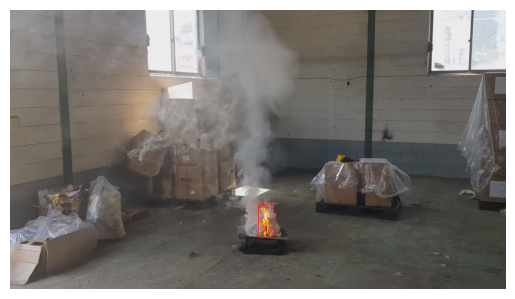

In [28]:
# 예시 이미지 로드
image_path = './data/train/fire/S3-N1102MF00344.jpg'
image = Image.open(image_path)
tr = transforms.ToTensor()
image = (tr(image)*255).to(torch.uint8)
# json_file =  './data/train/json/S3-N0404MF00085.json'


# 예시 경계 상자(x_min, y_min, x_max, y_max)
boxes = torch.tensor([[961,753,1022,881]])


# 이미지 시각화 
plt.imshow(draw_bounding_boxes(image, boxes, ['fire'],colors = 'red', width=2).permute(1,2,0))
plt.axis('off')
plt.show()


In [ ]:
img = read_image("./data/batch_02_vt/0002.jpg")

# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights)#, box_score_thresh=0.6)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=2, font_size=15)
im = to_pil_image(box.detach())
im.show()

In [10]:
# def get_transform(train):
#     transforms = []
#     # transforms.append(T.PILToTensor())
#     transforms.append(T.ConvertImageDtype(torch.float))
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
#     return T.Compose(transforms)

def get_transform():
    # transforms = []
    # transforms.append(T.PILToTensor())
    # transforms.append(T.ConvertImageDtype(torch.float))
    
        # transforms.append(T.RandomHorizontalFlip(0.5))
    mean1 = [90, 100, 100]
    std1 = [30, 32, 28]
    mean2 = [mean1[0]/255, mean1[1]/255, mean1[2]/255]
    std2 = [std1[0]/255, std1[1]/255, std1[2]/255]
    
    transforms = A.Compose([
                            # A.Normalize(mean=mean2, std=std2, max_pixel_value=255),
                            A.HorizontalFlip(p=1),
                            # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                            ToTensorV2(),
                        ], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels']))
    return transforms

In [11]:
dataset_path = './data/train' # Dataset 경로 지정 필요
val_path = dataset_path + '/train.json'
val_img_path = dataset_path + '/fire'
dataset_test = COCO_dataformat(val_img_path, val_path, get_transform())

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


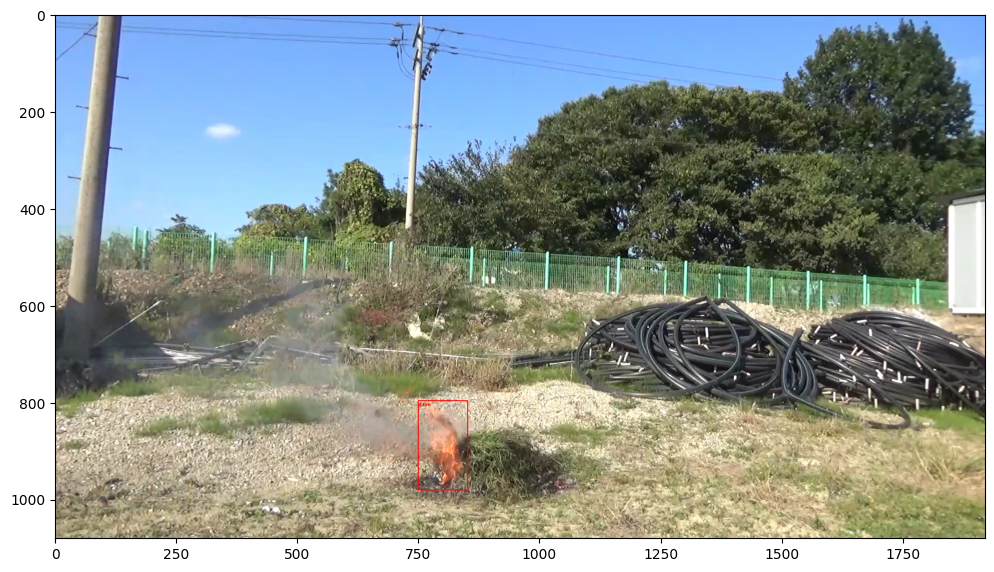

In [61]:
img, bbox = dataset_test[615]

fig = plt.figure(figsize=(12,8))
img_int = (img *255).type(torch.uint8)

plt.imshow(
    draw_bounding_boxes(img_int, bbox['boxes'], 
    ['fire' for _ in bbox['labels']], colors = 'red', width=2).permute(1,2,0)
)

In [12]:
img, target = dataset_test[615]
img_int = (img*255).type(torch.uint8)

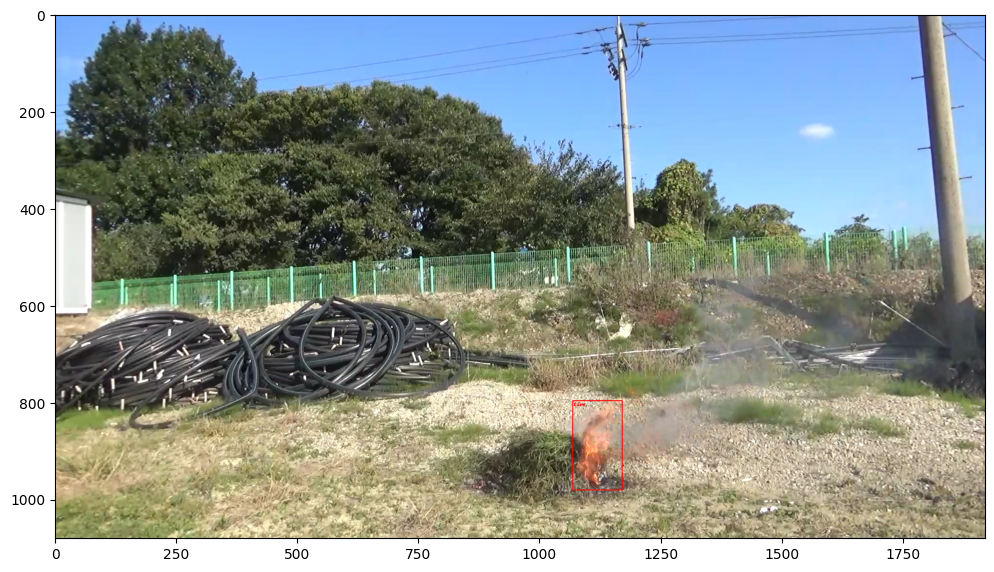

In [13]:
fig = plt.figure(figsize=(12,8))
img_int = (img*255).type(torch.uint8)

bbox = torch.tensor([list(box) for box in target['boxes']]).float()
bbox = torchvision.ops.box_convert(bbox, 'xywh', 'xyxy')
label = ['fire' for _ in target['labels']]
plt.imshow(
    draw_bounding_boxes(img_int, bbox,
    label, colors = 'red', width=2).permute(1,2,0)
)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = fasterrcnn_resnet50_fpn_v2()#weights = FasterRCNN_ResNet50_FPN_V2_Weights)#.to(device)model = fasterrcnn_resnet50_fpn_v2(weights=weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
# num_classes = len(coco.cats.keys())
# 미리 학습된 모델의 머리 부분을 새로운 것으로 교체합니다
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

load_model = torch.load('/home/seongwoo/workspace/FireDiff_experiment/model/demo_3.pt')

model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

/home/seongwoo/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/utils.py:232: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


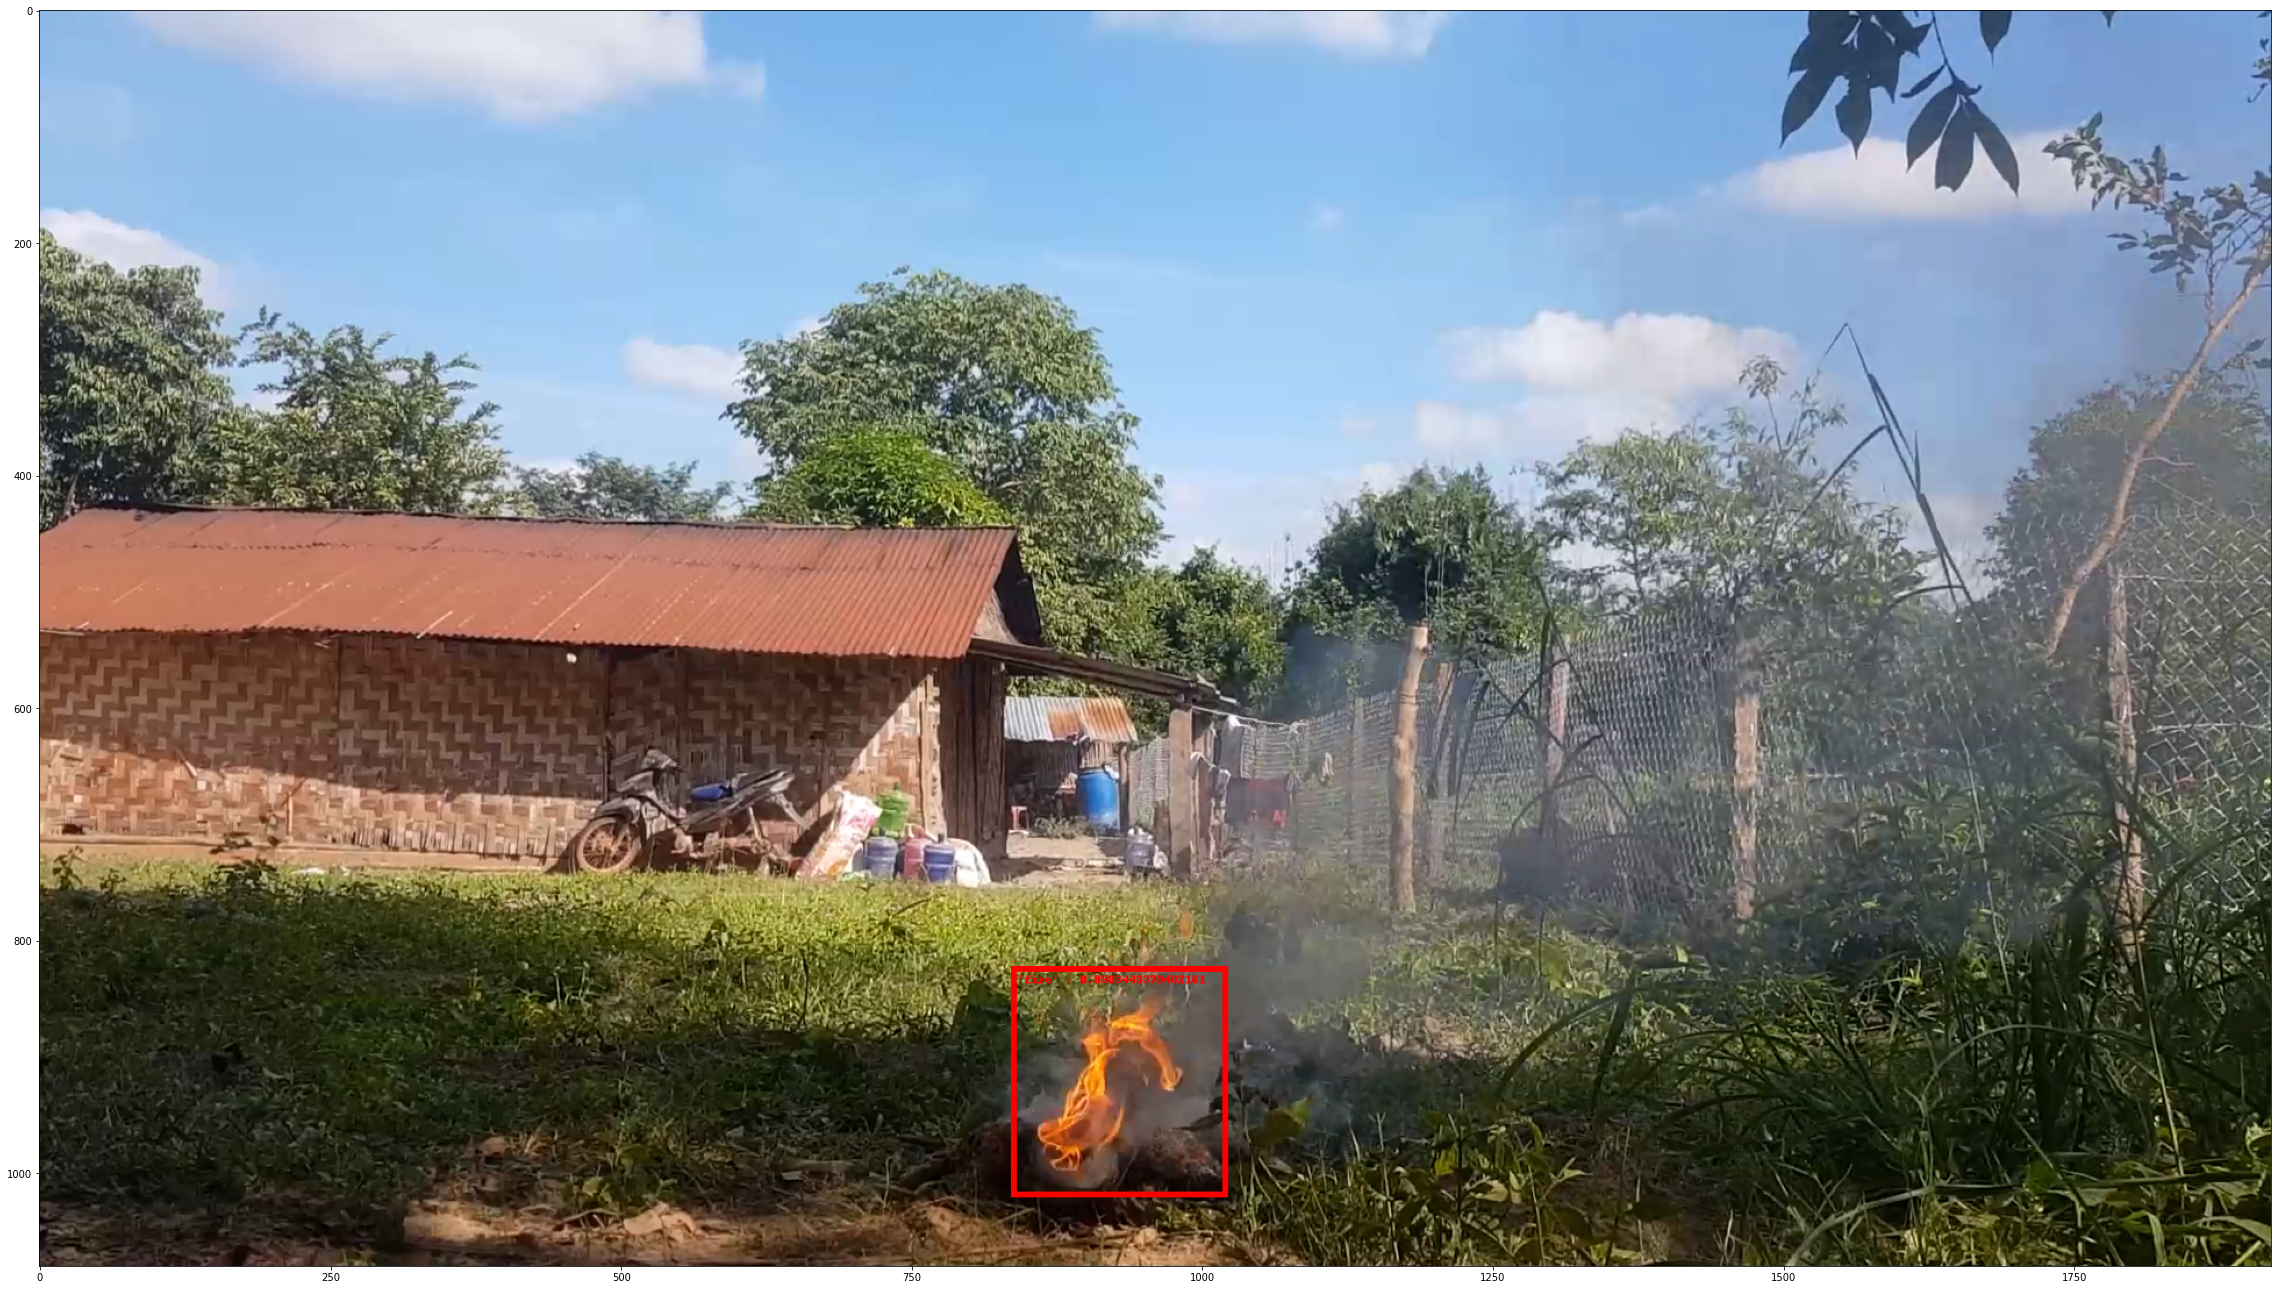

In [36]:
torch.cuda.empty_cache()
with torch.no_grad():
    load_model.eval()
    prediction = load_model([img.to(device)])
    pred = prediction[0]   
fig = plt.figure(figsize=(40,30))
plt.imshow(
    draw_bounding_boxes(img_int, pred['boxes'][pred['scores']>0.8], 
    [f"'fire' : {pred['scores'][pred['scores']>0.8][0].item()}" for i in pred['labels'][pred['scores']>0.8].tolist()],
    colors = 'red', width=5, font_size = 1).permute(1,2,0)
)

In [35]:
pred['scores'][pred['scores']>0.8][0].item()

0.8983443379402161